In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import time
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from utilities import EdwinRueda_utils
%matplotlib inline
print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("sklearn version: ", sklearn.__version__)

tensorflow version:  2.2.0
numpy version:  1.18.1
matplotlib version:  3.1.1
sklearn version:  0.21.3


<center> <h1> Proposed Method - Baseline</h1>

<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/ <br>
<b> You can cite this work with</b>:

@software{edwin_rueda_2020_3843381,<br>
  author       = {Edwin Rueda},<br>
  title        = {ejrueda/MasterUFPA: zenodo release},<br>
  month        = may,<br>
  year         = 2020,<br>
  publisher    = {Zenodo},<br>
  version      = {zenodo},<br>
  doi          = {10.5281/zenodo.3843381},<br>
  url          = {https://doi.org/10.5281/zenodo.3843381}<br>
}

### Notes:
- for the baseline, we implemented a SMOTE algorithm instead of a GAN architecture to generate synthetic samples.

-----------------
Proposed Method
-----------------


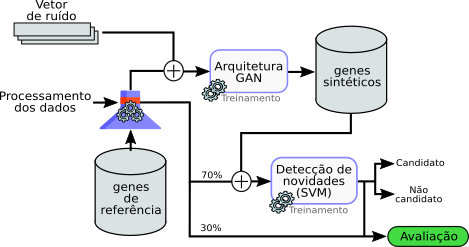

In [2]:
from PIL import Image
print("-----------------")
print("Proposed Method")
print("-----------------")
Image.open("../images/methodology_quali.png")

### Loading the preprocessed data
- Reference Genes are also loaded. Note: the <b>idnT</b> gene is not taken into account due to the high Coefficient of Variation of its gene expression.

In [3]:
data = pd.read_csv("../data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
data.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [4]:
rg = open("../data/reference_genes.txt").read().splitlines()
print(rg)

['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [5]:
rg_data = data.reindex(rg).dropna()
rg_data

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


### Scaling the data
- the data is scaled between -1 and 1 to facilitate the training of the GAN architecture

In [6]:
scaler = EdwinRueda_utils.scaler(xmin=-1, xmax=1)
scaler.fit(rg_data)
rg_data = scaler.transform(rg_data)
print("Reference genes scaled: ")
rg_data

Reference genes scaled: 


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


### Training the One-class classifier based on support vector machine
- <b>First</b>, we trained the proposed classifier based only on the initial data (without augmented the Reference genes set).
- <b>Notes:</b>
    - the selection of the hyperparameters of the classifier are based on the train and test data score.
    - cross-validation is used due the small number of samples.
    - the dataset is separated id two sets (70% to train the model and 30% to test the model), this split is random.

In [160]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

class ocsvm_utilities:
    """
    ocsvm_utilities class allows to train an one-class SVM with cross_validation
    and allows select the best initial parameters
    inputs:
        X: Dataframe with the RG to train the novelty detector. The index of this
           Dataframe must be the name of each gene.
        y: labels, for this aproach the target is a vector of ones with dimension
           equal to X.shape[0]
        test_size: the percentage of data to be used in the test step
        k_folds: the number of folds in the cross validation step
    """
    def __init__(self, X, y, test_size, k_folds):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.k_folds = k_folds
        self.cv_results = {}
        
    def ocsvm_score(self,estimator, X, y):
        """
        this function compute the recall score obtained in a one-class classifier.
        this function is used as an argument in cross validation
        inputs:
            estimator: trained estimator
            X: test data
            y: target
        output:
            recall socore
        """
        tp, fn = sum(estimator.predict(X)==1), sum(estimator.predict(X)!=1)
        return  tp/(tp + fn)
    
    def get_best_params(self, n_iter=5, param_grid):
        """
        This function compute a GridSearchCV for different training sets
        inputs:
            n_iter: number of iterations of the GridSearchCV in different training sets
                    ex: the training set is divided in 70% to train and 30% to test. For
                    default, this selection is made five times, then, the GridSearchCV is
                    used five times.
            param_grid: dictionary with the name and values of the parameter to change.
                        ex: {"nu": [.2, .5, .7]}
        return:
        
        """
        X_train, y_train = train_test_split(self.X, self.y, test_size=self.test_size)
        for i in range(n_iter):
            self.ocsvm = OneClassSVM(kernel="rbf", gamma="auto")
            self.gsCV = GridSearchCV(self.ocsvm, param_grid=param_grid)
        pass

In [161]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(kernel="rbf", gamma="auto")

In [162]:
g = GridSearchCV(clf, param_grid={"nu":np.linspace(.001,0.5, 10)}, scoring=ocsvm_score, cv=4)
g

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=OneClassSVM(cache_size=200, coef0=0.0, degree=3,
                                   gamma='auto', kernel='rbf', max_iter=-1,
                                   nu=0.5, random_state=None, shrinking=True,
                                   tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'nu': array([0.001     , 0.05644444, 0.11188889, 0.16733333, 0.22277778,
       0.27822222, 0.33366667, 0.38911111, 0.44455556, 0.5       ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function ocsvm_score at 0x7ff8e745fbf8>, verbose=0)

In [163]:
g.fit(rg_data, y=np.ones(rg_data.shape[0]))

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=OneClassSVM(cache_size=200, coef0=0.0, degree=3,
                                   gamma='auto', kernel='rbf', max_iter=-1,
                                   nu=0.5, random_state=None, shrinking=True,
                                   tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'nu': array([0.001     , 0.05644444, 0.11188889, 0.16733333, 0.22277778,
       0.27822222, 0.33366667, 0.38911111, 0.44455556, 0.5       ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function ocsvm_score at 0x7ff8e745fbf8>, verbose=0)

In [147]:
d_result = g.cv_results_
d_result.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_nu', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [148]:
g.best_estimator_

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
            max_iter=-1, nu=0.001, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [149]:
g.best_score_

0.4

In [150]:
nus = d_result["param_nu"].__array__()
scores = d_result["mean_test_score"]

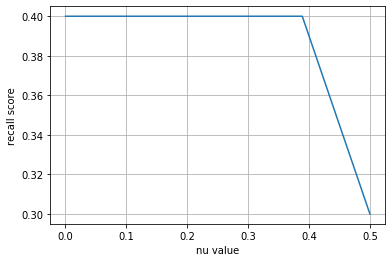

In [151]:
plt.plot(nus, scores)
plt.xlabel("nu value")
plt.ylabel("recall score")
plt.grid();

In [157]:
g.cv_results_

{'mean_fit_time': array([0.00249857, 0.00231618, 0.00130844, 0.00141972, 0.00116932,
        0.00120473, 0.00114816, 0.00115603, 0.00113517, 0.00113428]),
 'std_fit_time': array([8.71685478e-05, 3.56993764e-04, 2.26940613e-04, 4.48526988e-04,
        3.03131667e-05, 8.53193802e-05, 8.70533948e-06, 1.79182111e-05,
        4.21594907e-06, 9.48519484e-06]),
 'mean_score_time': array([0.00352639, 0.00304592, 0.00213265, 0.00189257, 0.00160241,
        0.00158054, 0.00157893, 0.0015887 , 0.0015713 , 0.0015775 ]),
 'std_score_time': array([1.11379297e-04, 8.51700954e-04, 7.69976594e-04, 3.60981555e-04,
        4.64191238e-05, 1.93511416e-05, 1.28806727e-05, 6.70227661e-06,
        1.54241343e-05, 9.03084133e-06]),
 'param_nu': masked_array(data=[0.001, 0.05644444444444444, 0.11188888888888888,
                    0.16733333333333333, 0.22277777777777777,
                    0.2782222222222222, 0.33366666666666667,
                    0.3891111111111111, 0.44455555555555554, 0.5],
           

In [49]:
clf = OneClassSVM(kernel="rbf", gamma="auto", nu=0.03)
clf.fit()